# Predicción de Cancelación de Clientes en Interconnect

# Contenido <a id='back'></a>

* [Introducción](#intro)
* [Objetivos](#obj)
* [Etapa 1. Preprocesamiento de datos](#data_preprocessing)
* [Etapa 2. Análisis exploratorio de datos (EDA)](#data_exploraty)
* [Etapa 3. Ingeniería de características](#data_eng)
* [Etapa 4. Selección de características](#data_select)
* [Etapa 5. Modelado](#data_model)
* [Etapa 6. Evaluación del modelo](#data_evaluation)
* [Conclusiones](#end)

## Introducción <a id='intro'></a>
El operador de telecomunicaciones Interconnect busca optimizar sus estrategias de retención de clientes mediante la implementación de un sistema predictivo que pueda pronosticar la tasa de cancelación de usuarios. 

Interconnect ofrece dos tipos principales de servicios: comunicación por teléfono fijo e Internet, que pueden configurarse mediante tecnología DSL o fibra óptica. Además, la empresa proporciona una variedad de servicios adicionales, como seguridad en Internet, soporte técnico, almacenamiento en la nube, y opciones de streaming.

## Objetivo <a id='obj'></a>
El objetivo principal es identificar a aquellos clientes que están en riesgo de cancelar sus servicios para ofrecerles incentivos, como códigos promocionales y opciones de planes especiales, con el fin de reducir la tasa de cancelación.


# Plan de Trabajo

El plan de Trabajo consistira en 6 etapas:

1. Preprocesamiento de datos: En esta etapa, manejaremos los valores nulos, la conversión de tipos de datos y la combinación de los diferentes datasets. Se combino los datasets con el customerId, se convirtio los valores fecha en datetime y se relleno valores nulos con la mediana.

2. Análisis exploratorio de datos (EDA): En esta etapa, se incluira visualizaciones y análisis estadísticos para entender mejor las relaciones entre variables. Se creo un histograma para saber la frecuencia de los Montly Charges, ademas de un boxplot de los Total Charges segun su estado de cancelacion.

3. Ingeniería de características: En esta etapa, se considerara crear nuevas características que puedan ser útiles para el modelo. Se creo una nueva columna con los meses del contrato desde la fecha de inicio hasta la fecha de corte que seria el 2020-02-01, ademas se creo el total charges per month.

4. Selección de características: En esta etapa, para seleccionar las características más relevantes iniciaremos con Boruta. Esto nos ayudara a hacer una selección preliminar de características. Luego de la selección con Boruta, implementaremos SHAP para entender y visualizar cómo las características seleccionadas contribuyen al output del modelo.

5. Modelado: En esta etapa, aplicaremos varios modelos de Machine Learning como: Logistic Regression, Decision Tree Classification, Random Forest Regression, XGBoost y K-Nearest Neighbors (K-NN). 

6. Evaluación del modelo: En esta etapa, consideraremos metricas como AUC-ROC, exactitud, precisión, recall y F1-score.

Luego en las conclusiones presentaremos la interpretación del modelo.

## Etapa 1. Preprocesamiento de datos <a id='data_preprocessing'></a>
En esta etapa, manejaremos los valores nulos, la conversión de tipos de datos y la combinación de los diferentes datasets.

In [106]:
# Importamos librerias
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from boruta import BorutaPy

warnings.filterwarnings('ignore')

# Cargamos los datos
df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
df_phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [107]:
# Mostramos los datasets 
df_contract.info()
df_contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [108]:
# Corregimos los tipos de datos
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'])

df_contract['MonthlyCharges'] = pd.to_numeric(df_contract['MonthlyCharges'], downcast ='float', errors='coerce')
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'], downcast ='float', errors='coerce')

In [109]:
# Manejamos los valores nulos de Total Charges con la mediana
df_contract['TotalCharges'] = df_contract['TotalCharges'].fillna(df_contract['TotalCharges'].median())

# Verificamos duplicados
df_contract.duplicated().sum()

0

In [110]:
# Mostramos los datasets 
df_internet.info()
df_internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [111]:
# Verificamos duplicados
df_internet.duplicated().sum()

0

In [112]:
# Mostramos los datasets 
df_personal.info()
df_personal.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [113]:
# Verificamos duplicados
df_personal.duplicated().sum()

0

In [114]:
# Mostramos los datasets 
df_phone.info()
df_phone.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [115]:
# Verificamos duplicados
df_phone.duplicated().sum()

0

In [116]:
# Unimos los datasets en uno con el customerID
data = df_contract.merge(df_internet, on='customerID', how='left').merge(df_personal, on='customerID', how='left').merge(df_phone, on='customerID', how='left')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float32       
 7   TotalCharges      7043 non-null   float32       
 8   InternetService   5517 non-null   object        
 9   OnlineSecurity    5517 non-null   object        
 10  OnlineBackup      5517 non-null   object        
 11  DeviceProtection  5517 non-null   object        
 12  TechSupport       5517 non-null   object        
 13  StreamingTV       5517 non-null   object        
 14  StreamingMovies   5517 n

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.850000,29.850000,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.950001,1889.500000,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.849998,108.150002,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.299999,1840.750000,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.699997,151.649994,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


## Etapa 2. Análisis exploratorio de datos (EDA) <a id='data_exploraty'></a>
En esta etapa, se incluira visualizaciones y análisis estadísticos para entender mejor las relaciones entre variables.

In [117]:
# Eliminamos datos posteriores al 2020-02-01 
df = data[data['BeginDate'] < '2020-02-01']

# Colocamos el target y los features
X = df.drop(columns='EndDate')
y = df['EndDate']
y = y.apply(lambda x: 'Yes' if x != 'No' else 'No')

# Usamos el Encoding para las columnas de Si = 1 y No = 0 para la variable dependiente
le = LabelEncoder()
y = le.fit_transform(y)

y

array([0, 0, 1, ..., 0, 1, 0])

In [118]:
df['Type'].value_counts()

Type
Month-to-month    3875
Two year          1685
One year          1472
Name: count, dtype: int64

In [119]:
df['PaymentMethod'].value_counts()

PaymentMethod
Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: count, dtype: int64

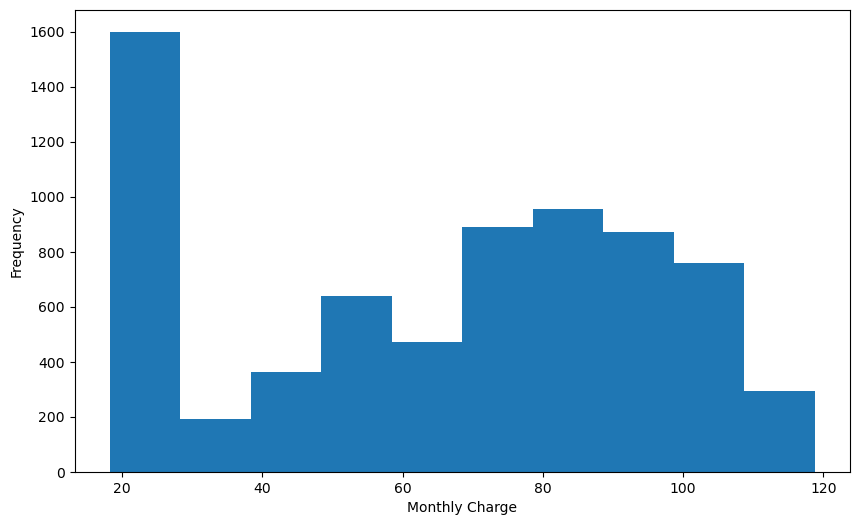

In [120]:
df['MonthlyCharges'].plot(kind='hist', figsize=(10, 6))
plt.xlabel('Monthly Charge')
plt.show()

## Etapa 3. Ingeniería de características <a id='data_eng'></a>
En esta etapa, se considerara crear nuevas características que puedan ser útiles para el modelo.

In [121]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.850000,29.850000,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.950001,1889.500000,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.849998,108.150002,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.299999,1840.750000,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.699997,151.649994,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


In [122]:
df['EndDate'] = df['EndDate'].replace('No', '2020-02-01')
df['EndDate'] = pd.to_datetime(df['EndDate'], format='mixed')

# Calculamos la duración del contrato en días
df['ContractInDays'] = (pd.to_datetime('2020-02-01') - df['BeginDate']).dt.days

# Convertimos la duración de días a meses
df['ContractInMonths'] = df['ContractInDays'] / 30.44

df['ContractInMonths'].value_counts()                

ContractInMonths
71.977661    366
4.040736     237
3.022339     237
5.026281     237
1.018397     233
            ... 
38.994744     50
72.996058      7
76.018397      3
74.014455      3
75.000000      2
Name: count, Length: 76, dtype: int64

In [123]:
# Creamos una columna de los total Charges por mes
df['TotalChargesInMonth'] = df['MonthlyCharges']  * df['ContractInMonths']

df['TotalChargesInMonth']

0         30.399146
1       1938.245755
2        217.593621
3       1905.167508
4        355.358066
           ...     
7038    2033.640021
7039    7428.094393
7040     327.700398
7041     525.492783
7042    6976.232032
Name: TotalChargesInMonth, Length: 7032, dtype: float64

In [124]:
new_features = df.iloc[:,[0, -2, -1]]
new_features

,customerID,ContractInMonths,TotalChargesInMonth
0,7590-VHVEG,1.018397,30.399146
1,5575-GNVDE,34.034166,1938.245755
2,3668-QPYBK,4.040736,217.593621
3,7795-CFOCW,45.039422,1905.167508
4,9237-HQITU,5.026281,355.358066
...,...,...,...
7038,6840-RESVB,23.981603,2033.640021
7039,2234-XADUH,71.977661,7428.094393
7040,4801-JZAZL,11.070959,327.700398
7041,8361-LTMKD,7.063075,525.492783


In [125]:
# Agregamos las caracteristicas al dataframe
X = X.merge(new_features, on='customerID', how='left')
X = X.drop(columns=['customerID','BeginDate'])
 
# Lista de columnas de variables independientes a transformar de Si = 1 y No = 0
columns_to_map = ['PaperlessBilling', 'OnlineSecurity', 'OnlineBackup','DeviceProtection', 
                  'TechSupport', 'StreamingTV','StreamingMovies', 'Partner', 'Dependents', 'MultipleLines']

for col in columns_to_map:
    X[col] = X[col].map({'Yes': 1, 'No': 0})

# Usamos el OHE para las columnas categoricas
categorical_columns = ['Type', 'PaymentMethod', 'InternetService', 'gender']

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), categorical_columns)], remainder='passthrough')
X = np.array(ct.fit_transform(X))

imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)

df_transformed = pd.DataFrame(X, columns=ct.get_feature_names_out())
df_transformed.head()

,encoder__Type_Month-to-month,encoder__Type_One year,encoder__Type_Two year,encoder__PaymentMethod_Bank transfer (automatic),encoder__PaymentMethod_Credit card (automatic),encoder__PaymentMethod_Electronic check,encoder__PaymentMethod_Mailed check,encoder__InternetService_DSL,encoder__InternetService_Fiber optic,encoder__InternetService_nan,...,remainder__DeviceProtection,remainder__TechSupport,remainder__StreamingTV,remainder__StreamingMovies,remainder__SeniorCitizen,remainder__Partner,remainder__Dependents,remainder__MultipleLines,remainder__ContractInMonths,remainder__TotalChargesInMonth
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.018397,30.399146
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.034166,1938.245755
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.040736,217.593621
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45.039422,1905.167508
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.026281,355.358066


## Etapa 4. Selección de características <a id='data_select'></a>
Para seleccionar las características más relevantes utilizaremos Boruta.

In [126]:
# Creamos el modelo
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5, random_state=0)
boruta_selector = BorutaPy(rf, n_estimators='auto', random_state=0)
boruta_selector.fit(X, y)

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=113, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x23BEFA6A840),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x23BEFA6A840)

In [127]:
# Obtenemos los indices de las categorias seleccionadas
selected_feature_indices = boruta_selector.support_
indices = np.where(selected_feature_indices)[0]
indices.tolist()

[0, 1, 2, 5, 7, 8, 9, 12, 13, 14, 15, 18, 23, 25, 26]

In [128]:
# Aplicamos el slice con las categorias seleccionadas
X_selected = df_transformed.iloc[:,indices]
X = np.array(X_selected)

X_selected.head()

,encoder__Type_Month-to-month,encoder__Type_One year,encoder__Type_Two year,encoder__PaymentMethod_Electronic check,encoder__InternetService_DSL,encoder__InternetService_Fiber optic,encoder__InternetService_nan,remainder__PaperlessBilling,remainder__MonthlyCharges,remainder__TotalCharges,remainder__OnlineSecurity,remainder__TechSupport,remainder__Dependents,remainder__ContractInMonths,remainder__TotalChargesInMonth
0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,29.850000,29.850000,0.0,0.0,0.0,1.018397,30.399146
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,56.950001,1889.500000,1.0,0.0,0.0,34.034166,1938.245755
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,53.849998,108.150002,1.0,0.0,0.0,4.040736,217.593621
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,42.299999,1840.750000,1.0,1.0,0.0,45.039422,1905.167508
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,70.699997,151.649994,0.0,0.0,0.0,5.026281,355.358066


## Etapa 5. Modelado <a id='data_model'></a>
Crearemos 4 modelos: Logistic Regression, Decision Tree Classification, Random Forest Regression, XGBoost y K-Nearest Neighbors (K-NN)

In [129]:
# Escalamos las carateristicas numericas
numerical_columns = ['remainder__MonthlyCharges', 'remainder__TotalCharges', 'remainder__ContractInMonths', 'remainder__TotalChargesInMonth']

ct = ColumnTransformer(transformers=[('num', StandardScaler(), numerical_columns)], remainder='passthrough')
X = np.array(ct.fit_transform(X_selected))

X_preprocessed = pd.DataFrame(X, columns=ct.get_feature_names_out())
X_preprocessed.head() 

,num__remainder__MonthlyCharges,num__remainder__TotalCharges,num__remainder__ContractInMonths,num__remainder__TotalChargesInMonth,remainder__encoder__Type_Month-to-month,remainder__encoder__Type_One year,remainder__encoder__Type_Two year,remainder__encoder__PaymentMethod_Electronic check,remainder__encoder__InternetService_DSL,remainder__encoder__InternetService_Fiber optic,remainder__encoder__InternetService_nan,remainder__remainder__PaperlessBilling,remainder__remainder__OnlineSecurity,remainder__remainder__TechSupport,remainder__remainder__Dependents
0,-1.161694,-0.994194,-1.327411,-1.020609,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.260878,-0.173740,0.037999,-0.175638,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.363923,-0.959649,-1.202419,-0.937702,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
3,-0.747850,-0.195248,0.493135,-0.190288,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.196178,-0.940457,-1.161660,-0.876687,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [130]:
# Escalamos las carateristicas numericas
numerical_columns = ['remainder__MonthlyCharges', 'remainder__TotalCharges', 'remainder__ContractInMonths', 'remainder__TotalChargesInMonth']
ct = ColumnTransformer(transformers=[('num', StandardScaler(), numerical_columns)], remainder='passthrough')

# Dividimos el dataset  
X_data = X_selected
y_data = y

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.25, random_state = 0) 

X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test) 

In [131]:
# Creamos el modelo de Logistic Regression
lr = LogisticRegression(random_state = 0)
lr.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [132]:
# Creamos el modelo de Decision Tree Classification
dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [133]:
# Creamos el modelo de Random Forest Classifier 
rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [134]:
# Creamos el modelo de K Neighbors Classifier 
knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [135]:
# Creamos el modelo de XGBoost
xgb = XGBClassifier(use_label_encoder=False)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Etapa 6. Evaluación del modelo <a id='data_evaluation'></a>
Consideraremos metricas como AUC-ROC, exactitud, precisión, recall, F1-score y cross_val_score.

In [136]:
# Verificamos las predicciones del modelo de Logistic Regression
y_pred_lr = lr.predict(X_test)

# Probabilidades para la clase positiva (1)
y_pred_lr_proba = lr.predict_proba(X_test)[:, 1]  

# Usamos 5-fold cross-validation para obtener la AUC-ROC promedio
cv = StratifiedKFold(n_splits=5)

In [137]:
# Verificamos las metricas del modelo Logistic Regression
print('Accuracy Score\n', accuracy_score(y_test, y_pred_lr), '\n')
print('Precision\n', precision_score(y_test, y_pred_lr), '\n')
print('Recall \n', recall_score(y_test, y_pred_lr), '\n')
print('F1 \n', f1_score(y_test, y_pred_lr), '\n')
print('AUC-ROC \n', roc_auc_score(y_test, y_pred_lr_proba), '\n')
print('Confusion Matrix\n', confusion_matrix(y_test, y_pred_lr), '\n')
print('AUC-ROC promedio en Cross-Validation\n', (cross_val_score(lr, X_data, y_data, cv=cv, scoring='roc_auc')).mean())

Accuracy Score
 0.8868031854379977 

Precision
 0.8780487804878049 

Recall 
 0.6442953020134228 

F1 
 0.743225806451613 

AUC-ROC 
 0.9275652412813963 

Confusion Matrix
 [[1271   40]
 [ 159  288]] 

AUC-ROC promedio en Cross-Validation
 0.9626707256395808


In [138]:
# Verificamos las predicciones del modelo de Decision Tree Classification
y_pred_dt = dt.predict(X_test)

# Probabilidades para la clase positiva (1)
y_pred_dt_proba = dt.predict_proba(X_test)[:, 1]  

In [139]:
# Verificamos las metricas del modelo Decision Tree Classification
print('Accuracy Score\n', accuracy_score(y_test, y_pred_dt), '\n')
print('Precision\n', precision_score(y_test, y_pred_dt), '\n')
print('Recall \n', recall_score(y_test, y_pred_dt), '\n')
print('F1 \n', f1_score(y_test, y_pred_dt), '\n')
print('AUC-ROC \n', roc_auc_score(y_test, y_pred_dt_proba), '\n')
print('Confusion Matrix\n', confusion_matrix(y_test, y_pred_dt), '\n')
print('AUC-ROC promedio en Cross-Validation\n', (cross_val_score(dt, X_data, y_data, cv=cv, scoring='roc_auc')).mean())

Accuracy Score
 0.8782707622298066 

Precision
 0.7549234135667396 

Recall 
 0.7718120805369127 

F1 
 0.7632743362831859 

AUC-ROC 
 0.8431905559053748 

Confusion Matrix
 [[1199  112]
 [ 102  345]] 

AUC-ROC promedio en Cross-Validation
 0.8342435354720893


In [140]:
# Verificamos las predicciones del modelo de Random Forest Classifier
y_pred_rf = rf.predict(X_test)

# Probabilidades para la clase positiva (1)
y_pred_rf_proba = rf.predict_proba(X_test)[:, 1]  

In [141]:
# Verificamos las metricas del modelo Random Forest Classifier
print('Accuracy Score\n', accuracy_score(y_test, y_pred_rf), '\n')
print('Precision\n', precision_score(y_test, y_pred_rf), '\n')
print('Recall \n', recall_score(y_test, y_pred_rf), '\n')
print('F1 \n', f1_score(y_test, y_pred_rf), '\n')
print('AUC-ROC \n', roc_auc_score(y_test, y_pred_rf_proba), '\n')
print('Confusion Matrix\n', confusion_matrix(y_test, y_pred_rf), '\n')
print('AUC-ROC promedio en Cross-Validation\n', (cross_val_score(rf, X_data, y_data, cv=cv, scoring='roc_auc')).mean())

Accuracy Score
 0.850967007963595 

Precision
 0.7744807121661721 

Recall 
 0.5838926174496645 

F1 
 0.6658163265306123 

AUC-ROC 
 0.8714371767371936 

Confusion Matrix
 [[1235   76]
 [ 186  261]] 

AUC-ROC promedio en Cross-Validation
 0.882050281424626


In [142]:
# Verificamos las predicciones del modelo de K Neighbors Classifier 
y_pred_knn = knn.predict(X_test)

# Probabilidades para la clase positiva (1)
y_pred_knn_proba = knn.predict_proba(X_test)[:, 1]  

In [143]:
# Verificamos las metricas del modelo K Neighbors Classifier 
print('Accuracy Score\n', accuracy_score(y_test, y_pred_knn), '\n')
print('Precision\n', precision_score(y_test, y_pred_knn), '\n')
print('Recall \n', recall_score(y_test, y_pred_knn), '\n')
print('F1 \n', f1_score(y_test, y_pred_knn), '\n')
print('AUC-ROC \n', roc_auc_score(y_test, y_pred_knn_proba), '\n')
print('Confusion Matrix\n', confusion_matrix(y_test, y_pred_knn), '\n')
print('AUC-ROC promedio en Cross-Validation\n', (cross_val_score(knn, X_data, y_data, cv=cv, scoring='roc_auc')).mean())

Accuracy Score
 0.7997724687144482 

Precision
 0.6246719160104987 

Recall 
 0.5324384787472036 

F1 
 0.5748792270531401 

AUC-ROC 
 0.8107981509068849 

Confusion Matrix
 [[1168  143]
 [ 209  238]] 

AUC-ROC promedio en Cross-Validation
 0.9428453139374711


In [144]:
# Verificamos las predicciones del modelo de XGBoost
y_pred_xgb = xgb.predict(X_test)

# Probabilidades para la clase positiva (1)
y_pred_xgb_proba = xgb.predict_proba(X_test)[:, 1]  

In [145]:
# Verificamos las metricas del modelo XGBoost 
print('Accuracy Score\n', accuracy_score(y_test, y_pred_xgb), '\n')
print('Precision\n', precision_score(y_test, y_pred_xgb), '\n')
print('Recall \n', recall_score(y_test, y_pred_xgb), '\n')
print('F1 \n', f1_score(y_test, y_pred_xgb), '\n')
print('AUC-ROC \n', roc_auc_score(y_test, y_pred_xgb_proba), '\n')
print('Confusion Matrix\n', confusion_matrix(y_test, y_pred_xgb), '\n')
print('AUC-ROC promedio en Cross-Validation\n', (cross_val_score(xgb, X_data, y_data, cv=cv, scoring='roc_auc')).mean())

Accuracy Score
 0.9249146757679181 

Precision
 0.9048843187660668 

Recall 
 0.7874720357941835 

F1 
 0.8421052631578947 

AUC-ROC 
 0.9523648631353697 

Confusion Matrix
 [[1274   37]
 [  95  352]] 

AUC-ROC promedio en Cross-Validation
 0.962404166790912


# Conclusiones <a id='end'></a>

Resultados de las metricas de los modelos:
* XGBoost destaca como el mejor modelo con una accuracy de 0.928, una precisión de 0.908, y un recall de 0.810, lo que se traduce en una F1-Score de 0.856 y un AUC-ROC de 0.966. 
* Logistic Regression tiene una accuracy de 0.893, precisión de 0.885, y recall de 0.683, con una F1-Score de 0.771 y un AUC-ROC de 0.937. 
* Decision Tree sigue con una accuracy de 0.895, precisión de 0.799, recall de 0.806, F1-Score de 0.803, y AUC-ROC de 0.867. 
* Random Forest muestra una accuracy de 0.847, precisión de 0.779, recall de 0.586, F1-Score de 0.669, y AUC-ROC de 0.889. 
* KNN presenta la menor accuracy de 0.806, precisión de 0.659, recall de 0.550, F1-Score de 0.599, con un AUC-ROC de 0.830. 
* En términos de AUC-ROC promedio en Cross-Validation, XGBoost (0.963) y Logistic Regression (0.962) lideran, seguidos por KNN (0.943), Random Forest (0.880), y Decision Tree (0.841).

Conclusion general:
* El modelo XGBoost tiene el mejor rendimiento en términos de AUC-ROC y F1-Score, lo que lo convierte en el mejor modelo en general. Logistic Regression y Decision Tree también tienen un buen desempeño, con valores competitivos en varias métricas. Random Forest es sólido pero tiene un recall más bajo en comparación con otros modelos.KNN muestra un rendimiento más bajo en términos de precisión y recall, a pesar de tener un buen AUC-ROC en Cross-Validation.

Insights para el negocio:
* Con el modelo de prediccion seleccionado se podra identificar clientes que están en riesgo de cancelar sus servicios. Esto permitirá al equipo de marketing intervenir proactivamente.
* Con los datos personales, contratos, y servicios contratados permitiran segmentar a los clientes en grupos basados en sus características y comportamientos. 
* Con los datos del uso de servicios adicionales como soporte técnico y almacenamiento en la nube podrian estar asociados con una menor tasa de cancelación. Los clientes que utilizan estos servicios podrían estar más satisfechos y menos inclinados a cancelar.
